# Clustering 
---
Based on the clean dataset, I will perform clustering of countries, prior to prediction.

**Contents:**
- [Import libraries and data](#Import-libraries-and-data)
- [Visualise solary energy potential](#Visualise-solar-energy-potential)
- [Clustering countries](#Clustering-countries)

### Import libraries and data

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
#for visualisation
import plotly.offline as py
from plotly.offline import iplot
py.offline.init_notebook_mode(connected=True)
from prettytable import PrettyTable
#for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import sys
!{sys.executable} -m pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
%matplotlib inline

In [2]:
#read clean data
solar_ctry = pd.read_csv('../data/solar-ctry-clean.csv')
#preview data
print("---------------------------- Top 5 rows of solar_ctry -------------------------")
display(solar_ctry.head())
print(f'Shape of solar_ctry : {solar_ctry.shape}')
print("----------------------------- Data types in solar_ctry ------------------------")
print(solar_ctry.dtypes)

---------------------------- Top 5 rows of solar_ctry -------------------------


Austria  Belgium  Bulgaria  Switzerland  Cyprus  Czech Republic  Germany  \
0      0.0      0.0       0.0          0.0     0.0             0.0      0.0   
1      0.0      0.0       0.0          0.0     0.0             0.0      0.0   
2      0.0      0.0       0.0          0.0     0.0             0.0      0.0   
3      0.0      0.0       0.0          0.0     0.0             0.0      0.0   
4      0.0      0.0       0.0          0.0     0.0             0.0      0.0   

   Denmark  Estonia  Spain  Finland  France  Greece  Croatia  Hungary  \
0      0.0      0.0    0.0      0.0     0.0     0.0      0.0      0.0   
1      0.0      0.0    0.0      0.0     0.0     0.0      0.0      0.0   
2      0.0      0.0    0.0      0.0     0.0     0.0      0.0      0.0   
3      0.0      0.0    0.0      0.0     0.0     0.0      0.0      0.0   
4      0.0      0.0    0.0      0.0     0.0     0.0      0.0      0.0   

   Ireland  Italy  Lithuania  Luxembourg  Latvia  Netherlands  Norway  Poland  \
0      0.0    0.0        0.0         0.0     0.0          0.0     0.0     0.0   
1      0.0    0.0        0.0         0.0     0.0          0.0     0.0     0.0   
2      0.0    0.0        0.0         0.0     0.0          0.0     0.0     0.0   
3      0.0    0.0        0.0         0.0     0.0          0.0     0.0     0.0   
4      0.0    0.0        0.0         0.0     0.0          0.0     0.0     0.0   

   Portugal  Romania  Slovenia  Slovakia  Sweden  United Kingdom  \
0       0.0      0.0       0.0       0.0     0.0             0.0   
1       0.0      0.0       0.0       0.0     0.0             0.0   
2       0.0      0.0       0.0       0.0     0.0             0.0   
3       0.0      0.0       0.0       0.0     0.0             0.0   
4       0.0      0.0       0.0       0.0     0.0             0.0   

                  time  hour  week  month  
0  1986-01-01 00:00:00     0     1      1  
1  1986-01-01 01:00:00     1     1      1  
2  1986-01-01 02:00:00     2     1      1  
3  1986-01-01 03:00:00     3     1      1  
4  1986-01-01 04:00:00     4     1      1

Shape of solar_ctry : (262968, 33)
----------------------------- Data types in solar_ctry ------------------------
Austria           float64
Belgium           float64
Bulgaria          float64
Switzerland       float64
Cyprus            float64
Czech Republic    float64
Germany           float64
Denmark           float64
Estonia           float64
Spain             float64
Finland           float64
France            float64
Greece            float64
Croatia           float64
Hungary           float64
Ireland           float64
Italy             float64
Lithuania         float64
Luxembourg        float64
Latvia            float64
Netherlands       float64
Norway            float64
Poland            float64
Portugal          float64
Romania           float64
Slovenia          float64
Slovakia          float64
Sweden            float64
United Kingdom    float64
time               object
hour                int64
week                int64
month               int64
dtype: object


### Visualise solar energy potential
Use a choropleth map to visualise areas with the most or least energy potential. 

In [3]:
#create an average exposure to sunlight column for each country
def choropleth_data(df):
    '''function that formats data for choropleth mapping'''
    df1 = df.drop(columns=['time','hour','week','month']) #drop unnecessary columns
    df1.loc['mean'] = df1.mean() #get the mean of each country
    df1 = df1.loc[['mean'],:] # create df with just hte countries and th emean
    df1 = df1.T.reset_index().rename(columns = {'index':'country'}) #rename index column to country
    return df1

In [4]:
#run function 
solar_ctry_viz = choropleth_data(solar_ctry)

In [5]:
#view in choropleth map
color = [[0,'rgb(242,240,247)'],
         [0.2, 'rgb(218,218,235)'],
         [0.4, 'rgb(188,189,220)'],
         [0.6, 'rgb(158,154,200)'],
         [0.8, 'rgb(117,107,177)'],
         [1.0, 'rgb(84,39,143)']]

data = [dict(type='choropleth',
            colorscale=color,
            autocolorscale=False,
            locations=solar_ctry_viz['country'],
            z=solar_ctry_viz['mean'],
            locationmode='country names',
            text=solar_ctry_viz['country'],
            marker=dict(line=dict(color='rgb(0,0,0)',width=2)),
            colorbar=dict(title="Energy Potential (%)"))]

layout = dict(title='Average Energy Potential of European Countries from 1986-2015',
             geo=dict(
             scope='europe',
             showlakes=True,
             lakecolor='rgb(255,255,255)'))

fig=dict(data=data,layout=layout)
iplot(fig, filename='choropleth-map-energy')

From here we see the regions with the higher solar energy potential are lower, nearer to the Equator. This makes sense since the sun's rays stirke Earth's surface most directly at the Equator. 

This also explains the high correlation between neighbouring states as their exposure to sun is similar.

### Clustering countries
There are a total of 29 countries but they can be grouped in clusters for analysis. This is where countries with similar energy potential would be in one cluster together. It would then be a more useful analysis to look at one country from each cluster as opposed to analysing each of the 28 countries. 

As there is voluminous data, I'd take just the last year records (ie. 2015) and determine clusters based on these.

In [6]:
%%time
#compute number of hours in the last year
last_year = 24*365
#transpose the period
solar_ctry_2015_transposed = solar_ctry[-last_year:].T
#drop time, hour, month, week
solar_ctry_2015_transposed.drop(index=['time','hour','week','month'], inplace=True)
#check
print(" head ".center(18,'-'))
display(solar_ctry_2015_transposed.head())
print(" tail ".center(18,'-'))
display(solar_ctry_2015_transposed.tail())

------ head ------


254208 254209 254210 254211 254212 254213     254214     254215  \
Austria          0      0      0      0      0      0          0   0.027972   
Belgium          0      0      0      0      0      0          0          0   
Bulgaria         0      0      0      0      0      0  0.0357931   0.192023   
Switzerland      0      0      0      0      0      0          0  0.0144632   
Cyprus           0      0      0      0      0      0          0          0   

                254216    254217    254218    254219    254220     254221  \
Austria       0.113287  0.127273  0.116084  0.113287  0.109091  0.0993007   
Belgium      0.0197097  0.232778  0.392154  0.456041  0.442448   0.302101   
Bulgaria      0.302919  0.354551  0.382422  0.369163  0.313377   0.225553   
Switzerland   0.107674  0.163776  0.185244  0.186777  0.181647   0.175124   
Cyprus               0         0         0         0         0          0   

                254222     254223 254224 254225 254226 254227 254228 254229  \
Austria      0.0643357   0.020979      0      0      0      0      0      0   
Belgium       0.183844  0.0292247      0      0      0      0      0      0   
Bulgaria     0.0656618          0      0      0      0      0      0      0   
Switzerland   0.141796  0.0538778      0      0      0      0      0      0   
Cyprus               0          0      0      0      0      0      0      0   

            254230 254231 254232 254233 254234 254235 254236 254237  \
Austria          0      0      0      0      0      0      0      0   
Belgium          0      0      0      0      0      0      0      0   
Bulgaria         0      0      0      0      0      0      0      0   
Switzerland      0      0      0      0      0      0      0      0   
Cyprus           0      0      0      0      0      0      0      0   

                254238     254239      254240     254241    254242    254243  \
Austria              0  0.0293706    0.163636   0.272727  0.331469  0.369231   
Belgium              0          0  0.00441768  0.0295645  0.068644  0.169231   
Bulgaria     0.0289495   0.152873    0.261095   0.298811   0.28495  0.285919   
Switzerland          0  0.0144457   0.0925494   0.181713  0.226897  0.232371   
Cyprus               0          0           0          0         0         0   

               254244    254245     254246     254247 254248 254249 254250  \
Austria      0.265734  0.138462  0.0755245   0.020979      0      0      0   
Belgium      0.289188  0.341861   0.257245  0.0659254      0      0      0   
Bulgaria     0.247331  0.154392  0.0455985          0      0      0      0   
Switzerland  0.209207  0.130143  0.0924169  0.0314964      0      0      0   
Cyprus              0         0          0          0      0      0      0   

            254251 254252 254253 254254 254255 254256 254257 254258 254259  \
Austria          0      0      0      0      0      0      0      0      0   
Belgium          0      0      0      0      0      0      0      0      0   
Bulgaria         0      0      0      0      0      0      0      0      0   
Switzerland      0      0      0      0      0      0      0      0      0   
Cyprus           0      0      0      0      0      0      0      0      0   

            254260 254261     254262     254263      254264     254265  \
Austria          0      0          0  0.0391608    0.226573   0.299301   
Belgium          0      0          0          0  0.00373804  0.0169911   
Bulgaria         0      0  0.0130271  0.0973003    0.162705   0.266804   
Switzerland      0      0          0  0.0145293   0.0822097   0.150378   
Cyprus           0      0          0          0           0          0   

                254266     254267     254268     254269     254270     254271  \
Austria       0.324476   0.276923   0.236364   0.151049  0.0741259  0.0181818   
Belgium      0.0275256  0.0397591  0.0642263  0.0462157  0.0278654  0.0166513   
Bulgaria      0.303392   0.307404   0.287228   0.216665  0.083526

------ tail ------


254208 254209 254210 254211 254212 254213     254214  \
Romania             0      0      0      0      0      0  0.0297769   
Slovenia            0      0      0      0      0      0          0   
Slovakia            0      0      0      0      0      0          0   
Sweden              0      0      0      0      0      0          0   
United Kingdom      0      0      0      0      0      0          0   

                   254215     254216     254217     254218     254219  \
Romania          0.126217   0.160196   0.168764   0.156882   0.145611   
Slovenia        0.0112465    0.11436   0.153591   0.143488   0.132949   
Slovakia        0.0630976   0.127954   0.143379   0.101459  0.0879493   
Sweden                  0  0.0255903  0.0287744  0.0243682  0.0295108   
United Kingdom          0  0.0143603  0.0187663  0.0357376  0.0426458   

                   254220     254221     254222     254223      254224 254225  \
Romania          0.119438  0.0762546  0.0243034          0           0      0   
Slovenia         0.121438   0.101175  0.0400243  0.0035177           0      0   
Slovakia        0.0806172  0.0594334  0.0319711          0           0      0   
Sweden          0.0269909  0.0257397   0.015349          0           0      0   
United Kingdom  0.0488468  0.0437337  0.0351393  0.0177328  0.00875762      0   

               254226 254227 254228 254229 254230 254231 254232 254233 254234  \
Romania             0      0      0      0      0      0      0      0      0   
Slovenia            0      0      0      0      0      0      0      0      0   
Slovakia            0      0      0      0      0      0      0      0      0   
Sweden              0      0      0      0      0      0      0      0      0   
United Kingdom      0      0      0      0      0      0      0      0      0   

               254235 254236 254237    254238     254239     254240  \
Romania             0      0      0  0.026688   0.111632   0.168462   
Slovenia            0      0      0         0  0.0260396   0.160642   
Slovakia            0      0      0         0  0.0335772  0.0866001   
Sweden              0      0      0         0          0  0.0216156   
United Kingdom      0      0      0         0          0  0.0144147   

                   254241     254242     254243     254244     254245  \
Romania          0.181327   0.151029   0.141133   0.109727   0.076031   
Slovenia         0.201956   0.274091   0.310509   0.290087   0.167587   
Slovakia         0.145013   0.183728   0.203672   0.152998  0.0787466   
Sweden          0.0352721  0.0533391  0.0616995  0.0666826  0.0287609   
United Kingdom  0.0794169   0.193538   0.287261   0.327187   0.289763   

                   254246      254247      254248 254249 254250 254251 254252  \
Romania          0.029628           0           0      0      0      0      0   
Slovenia        0.0529856  0.00346566           0      0      0      0      0   
Slovakia        0.0238198           0           0      0      0      0      0   
Sweden          0.0151275           0           0      0      0      0      0   
United Kingdom   0.201915   0.0673956  0.00883921      0      0      0      0   

               254253 254254 254255 254256 254257 254258 254259 254260 254261  \
Romania             0      0      0      0      0      0      0      0      0   
Slovenia            0      0      0      0      0      0      0      0      0   
Slovakia            0      0      0      0      0      0      0      0      0   
Sweden              0      0      0      0      0      0      0      0      0   
United Kingdom      0      0      0      0      0      0      0      0      0   

                   254262     254263     254264     254265     254266  \
Romania         0.0284488   0.104386     0.1448   0.154475   0.155627   
Slovenia                0  0.0108888  0.0748645   0.111259    0.12801   
Slovakia                0  0.0567598   0.170752   0.267193   0.299319   
Sweden                  0          0  0.025

Wall time: 6.3 s


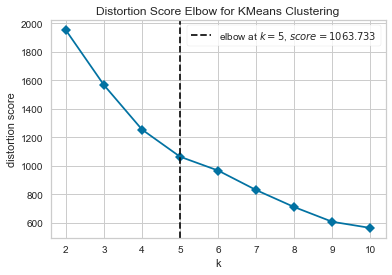

Wall time: 2.23 s


In [7]:
%%time
#instantiate 
km = KMeans()
elbow_viz = KElbowVisualizer(km, k=(2,11), timings=False)
#fit and draw
elbow_viz.fit(solar_ctry_2015_transposed)
elbow_viz.poof()
plt.show()

**Distortion score** is the sum of squared distances from each point to its assigned center (ie. sum of squared errors). The elbow method seeks to identify a point as number of clusters increase, where the distortion score start to flatten, forming the elbow. This is determined to be the ideal number of clusters for the data.

The above graph shows that 5 clusters is ideal. The elbow method mostly serves as a guide, and should be considered alongside **silhouette score**. Silhouette score considers both the average intra-cluster distance and average inter-cluster distance. A score close to 1 means that the clusters are well apart from each other and clearly distinguished. 

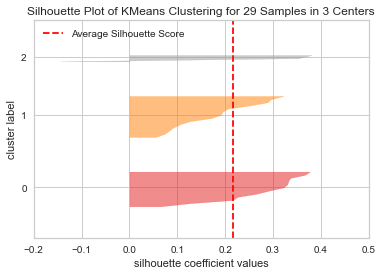

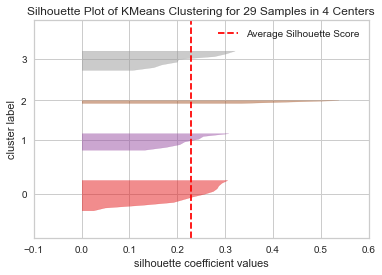

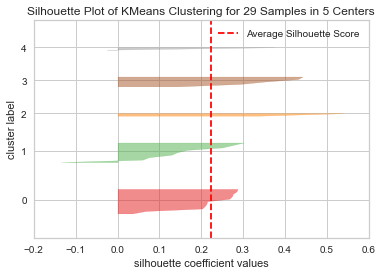

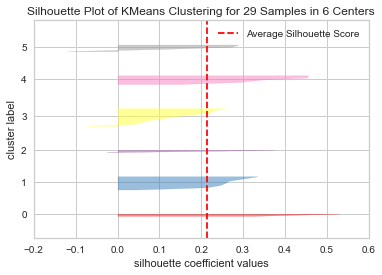

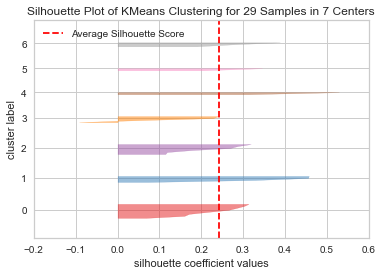

In [8]:
for i in range(3,8):
    km_set = KMeans(i)
    sil_viz = SilhouetteVisualizer(km_set)
    sil_viz.fit(solar_ctry_2015_transposed)    
    sil_viz.poof()
    plt.show()

From visual above, we want to lookout for a few things :

**1. Positive silhouette coefficient values**

A negative silhouette coefficient value means that the sample (in this case, the country) is better of assigned to another cluster. Based on the plots, clusters of 6 and 7 are suboptimal.

**2. Silhouette score for cluster above the average silhouette score**

Clusters of 6 and 7 have cluster below the average silhouette score, so we'll consider just the clusters of 3, 4 or 5.

**3. Thickness of the silhouette plot**

Between 3, 4 and 5 clusters, plot with 5 clusters have a more uniform cluster thickness than the rest. 5 clusters might be the optimal one. 

Before deciding, I also plot the intercluster distance for 5 clusters and 6 clusters for more assurance of the optimal number of clusters

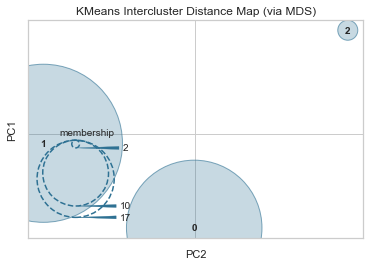

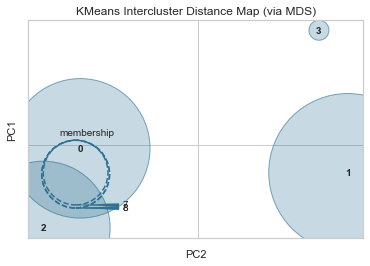

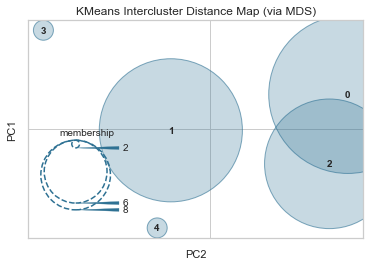

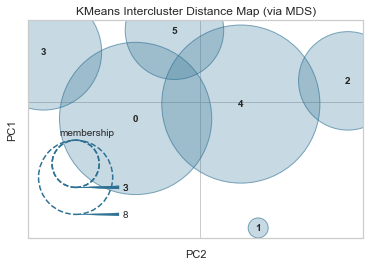

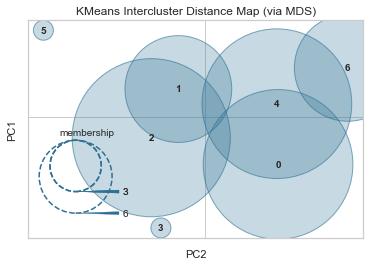

In [9]:
# visualise intercluster distance for 5 and 6 clusters
clust = [3,4,5,6,7]

for i in clust:
    km_intercluster = KMeans(i)
    intclus_viz = InterclusterDistance(km_intercluster)
    intclus_viz.fit(solar_ctry_2015_transposed)   
    intclus_viz.show();

There seem to be no clear distinct groups for all clusters. However from 6 clusters onwards, there seem to be too much overlapping regions. Apart from this, for clusters of 3 or or 5, the intercluster distance map was inconclusive. 

However, we bear in mind that it is not essential that we get exact distinct clusters since the purpose of clustering is mainly for easier analysis and would not affect prediction of solar energy potential for the countries. 

Based on this, we will go forward with **5 clusters** using KMeans clustering. 

In [10]:
# add cluster labels to the respective countries
km = KMeans(n_clusters=5,max_iter=50)
km.fit(solar_ctry_2015_transposed) #fit
cluster_labels = km.labels_ #set cluster labels
solar_ctry_2015_transposed = solar_ctry_2015_transposed.assign(cluster=cluster_labels) # assign to original dataframe
#preview data
solar_ctry_2015_transposed.head()

254208 254209 254210 254211 254212 254213     254214     254215  \
Austria          0      0      0      0      0      0          0   0.027972   
Belgium          0      0      0      0      0      0          0          0   
Bulgaria         0      0      0      0      0      0  0.0357931   0.192023   
Switzerland      0      0      0      0      0      0          0  0.0144632   
Cyprus           0      0      0      0      0      0          0          0   

                254216    254217    254218    254219    254220     254221  \
Austria       0.113287  0.127273  0.116084  0.113287  0.109091  0.0993007   
Belgium      0.0197097  0.232778  0.392154  0.456041  0.442448   0.302101   
Bulgaria      0.302919  0.354551  0.382422  0.369163  0.313377   0.225553   
Switzerland   0.107674  0.163776  0.185244  0.186777  0.181647   0.175124   
Cyprus               0         0         0         0         0          0   

                254222     254223 254224 254225 254226 254227 254228 254229  \
Austria      0.0643357   0.020979      0      0      0      0      0      0   
Belgium       0.183844  0.0292247      0      0      0      0      0      0   
Bulgaria     0.0656618          0      0      0      0      0      0      0   
Switzerland   0.141796  0.0538778      0      0      0      0      0      0   
Cyprus               0          0      0      0      0      0      0      0   

            254230 254231 254232 254233 254234 254235 254236 254237  \
Austria          0      0      0      0      0      0      0      0   
Belgium          0      0      0      0      0      0      0      0   
Bulgaria         0      0      0      0      0      0      0      0   
Switzerland      0      0      0      0      0      0      0      0   
Cyprus           0      0      0      0      0      0      0      0   

                254238     254239      254240     254241    254242    254243  \
Austria              0  0.0293706    0.163636   0.272727  0.331469  0.369231   
Belgium              0          0  0.00441768  0.0295645  0.068644  0.169231   
Bulgaria     0.0289495   0.152873    0.261095   0.298811   0.28495  0.285919   
Switzerland          0  0.0144457   0.0925494   0.181713  0.226897  0.232371   
Cyprus               0          0           0          0         0         0   

               254244    254245     254246     254247 254248 254249 254250  \
Austria      0.265734  0.138462  0.0755245   0.020979      0      0      0   
Belgium      0.289188  0.341861   0.257245  0.0659254      0      0      0   
Bulgaria     0.247331  0.154392  0.0455985          0      0      0      0   
Switzerland  0.209207  0.130143  0.0924169  0.0314964      0      0      0   
Cyprus              0         0          0          0      0      0      0   

            254251 254252 254253 254254 254255 254256 254257 254258 254259  \
Austria          0      0      0      0      0      0      0      0      0   
Belgium          0      0      0      0      0      0      0      0      0   
Bulgaria         0      0      0      0      0      0      0      0      0   
Switzerland      0      0      0      0      0      0      0      0      0   
Cyprus           0      0      0      0      0      0      0      0      0   

            254260 254261     254262     254263      254264     254265  \
Austria          0      0          0  0.0391608    0.226573   0.299301   
Belgium          0      0          0          0  0.00373804  0.0169911   
Bulgaria         0      0  0.0130271  0.0973003    0.162705   0.266804   
Switzerland      0      0          0  0.0145293   0.0822097   0.150378   
Cyprus           0      0          0          0           0          0   

                254266     254267     254268     254269     254270     254271  \
Austria       0.324476   0.276923   0.236364   0.151049  0.0741259  0.0181818   
Belgium      0.0275256  0.0397591  0.0642263  0.0462157  0.0278654  0.0166513   
Bulgaria      0.303392   0.307404   0.287228   0.216665  0.083526

In [11]:
# print countries in each cluster in a table
y = PrettyTable(title='Countries by Cluster', header_style='title', max_table_width=110)
y.field_names = ['Cluster','Countries']
for k in range(5):
    y.add_row([k, solar_ctry_2015_transposed[solar_ctry_2015_transposed['cluster']== k].index.values])
    
print(y)

+-------------------------------------------------------------------------------+
|                              Countries by Cluster                             |
+---------+---------------------------------------------------------------------+
| Cluster |                              Countries                              |
+---------+---------------------------------------------------------------------+
|    0    |                         ['Cyprus' 'Norway']                         |
|    1    | ['Austria' 'Bulgaria' 'Czech Republic' 'Greece' 'Croatia' 'Hungary' |
|         |               'Italy' 'Romania' 'Slovenia' 'Slovakia']              |
|    2    |   ['Belgium' 'Switzerland' 'Germany' 'Denmark' 'France' 'Ireland'   |
|         |             'Luxembourg' 'Netherlands' 'United Kingdom']            |
|    3    |     ['Estonia' 'Finland' 'Lithuania' 'Latvia' 'Poland' 'Sweden']    |
|    4    |                         ['Spain' 'Portugal']                        |
+---------+-----

Now that we have clustered the countries, I pick a country in each cluster for further analysis. 

| Cluster | Country Selected |
| :--: | :--: |
| 0 | Netherlands |
| 1 | Croatia | 
| 2 | Finland |
| 3 | Spain |
| 4 | Norway | 

Refer to [this notebook](03-data-exploration.ipynb) for data exploration and analysis.